In [1]:
import obstacle_distance_and_gradient as Obt
import Jxt_function as Jxtfunct
import numpy as np
import matplotlib.pyplot as plt
import math
from J_x_t_function_gamma import J_x_t_func

In [2]:
def dist_grad_closest(segment_info, x):
    A, B = segment_info
    AB = B - A
    t = np.dot(x - A, AB) / np.dot(AB, AB)
    t = np.clip(t, 0, 1)  # Clamp t to the segment
    closest = A + t * AB
    d = np.linalg.norm(x - closest)
    if d != 0:
        grad_d = (x - closest) / d
    else:
        grad_d = np.zeros_like(x)
    return d, grad_d, closest

def closest_point_on_square(obs_info, x_current):
    min_dist = float('inf')
    closest_pt = None
    closest_segment_key = None

    # Iterate through each line segment to find the closest point
    for key, segment in obs_info.items():
        d, _, pt = dist_grad_closest(segment, x_current)
        if d < min_dist:
            min_dist = d
            closest_pt = pt
            closest_segment_key = key

    return closest_pt, closest_segment_key

def compute_s_star_x_star(obs_info, segment_key, x_current):
    x_0 = obs_info[segment_key][1]
    x_1 = obs_info[segment_key][0]
    s_star = np.dot((x_current - x_0), (x_1 - x_0)) / (np.linalg.norm(x_1 - x_0))**2
    
    if s_star < 0:
        x_star = x_0
    elif s_star > 1:
        x_star = x_1
    else:
        x_star = (1 - s_star) * x_0 + s_star * x_1

    return s_star, x_star

import numpy as np

def compute_segments(obs_info):
    # Extract the diagonal vertices
    vertexA, vertexB = obs_info[0]
    
    # Identify the top-left and bottom-right vertices
    top_left = np.array([min(vertexA[0], vertexB[0]), max(vertexA[1], vertexB[1])])
    bottom_right = np.array([max(vertexA[0], vertexB[0]), min(vertexA[1], vertexB[1])])
    
    # Compute the other two vertices
    top_right = np.array([bottom_right[0], top_left[1]])
    bottom_left = np.array([top_left[0], bottom_right[1]])
    
    # Create the segments (edges) in clockwise order
    segment_info = {
        0: [top_right, top_left],
        1: [top_left, bottom_left],
        2: [bottom_left, bottom_right],
        3: [bottom_right, top_right]
    }
    
    return segment_info


In [3]:
def dist_grad_closest(segment_info, x):
    A, B = segment_info
    AB = B - A
    t = np.dot(x - A, AB) / np.dot(AB, AB)
    t = np.clip(t, 0, 1)  # Clamp t to the segment
    closest = A + t * AB
    d = np.linalg.norm(x - closest)
    if d != 0:
        grad_d = (x - closest) / d
    else:
        grad_d = np.zeros_like(x)
    return d, grad_d, closest

In [4]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import obstacle_distance_and_gradient as Obt
import numpy as np


# In[2]:


#!/usr/bin/env python3

# -*- coding: utf-8 -*-

'''

Author: Guang Yang

'''



from gurobipy import *

import math

import numpy as np





class QPcontroller:

    def __init__(self, config={}):

        self.k_cbf = 8.0 #CBF coefficient
        self.k_cbf2 = 6

        self.epsilon = 0.4 #Finite time CLF coefficient

        self.m = Model("CBF_CLF_QP")
        self.m.setParam('OutputFlag', 0)

        self.num_of_states = 2

        self.num_of_control_inputs = 2

        self.u1_upper_lim = 10000 # From Create Autonomy

        self.u1_lower_lim = -10000

        self.u2_upper_lim = 10000

        self.u2_lower_lim = -10000

        self.u3_upper_lim = 10000

        self.u3_lower_lim = -10000

        self.desk_height = 0.59
        self.gaussian = []
        
        self.sigma = 0.35
        
        self.A = 0.5
        
        self.Jmax = 0.20
        
        self.dt = 0.1

        self.goal = None
        
        self.x_s =[]



        # Control Variables

        self.u1 = self.m.addVar(lb=self.u1_lower_lim, ub=self.u1_upper_lim,vtype=GRB.CONTINUOUS, name="x1_input_acceleration")

        self.u2 = self.m.addVar(lb=self.u2_lower_lim, ub=self.u2_upper_lim,vtype=GRB.CONTINUOUS, name="x2_input_acceleration")

    

        # Soft Constraint Variable for CLF

        self.delta = self.m.addVar(lb=-30, ub=30,vtype=GRB.CONTINUOUS, name="relaxation_CLF")








    def set_goal(self, goal):

        self.goal = goal



    def get_next_wp(self, action=None, curr_pose=None, curr_vel=None, obs_info={}):

        _, target_vel, target_pose = self.generate_control(curr_pose, obs_info)

        return None, target_vel, target_pose
    
    def generate_control(self,x_current,quad_rad,x_noise, obs_info):

        #self.control_u3 = self.solution[2].x
        k_ref_x1 = self.goal[0] - x_current[0]
        k_ref_x2 = self.goal[1] - x_current[1]
        #self.m.reset()
        self.m.remove(self.m.getConstrs())
        
        
        num_of_obstacles = len(obs_info) #For later use when more obstacles are involved
        for i in range(0,num_of_obstacles):

            rect = obs_info[i]
            box = Obt.Rectangle(rect[0],rect[1])
            top_left = np.array([x_current[0]-quad_rad , x_current[1] + quad_rad])
            top_right = np.array([x_current[0]+quad_rad , x_current[1] + quad_rad])
            bottom_left = np.array([x_current[0]-quad_rad , x_current[1] - quad_rad])
            bottom_right = np.array([x_current[0]+quad_rad , x_current[1] - quad_rad])
            
            d1= box.dist_grad_closest(top_left)[0] - quad_rad
            d2= box.dist_grad_closest(top_right)[0] - quad_rad
            d3= box.dist_grad_closest(bottom_left)[0] - quad_rad
            d4= box.dist_grad_closest(bottom_right)[0] - quad_rad
            
            grad_d1= box.dist_grad_closest(top_left)[1]
            grad_d2= box.dist_grad_closest(top_right)[1]
            grad_d3= box.dist_grad_closest(bottom_left)[1]
            grad_d4= box.dist_grad_closest(bottom_right)[1]
            
            min_distance = min(d1, d2, d3, d4)

            # Assign the appropriate grad_d based on the minimum distance value
            if min_distance == d1:
                grad_d = grad_d1
            elif min_distance == d2:
                grad_d = grad_d2
            elif min_distance == d3:
                grad_d = grad_d3
            else:
                grad_d = grad_d4

            d = min_distance
            
            self.m.addConstr(grad_d[0] *self.u1 + grad_d[1] *self.u2 + self.k_cbf*d >= 0, f"CBF_Constraint_h_left_")
        
            min_index = np.argmin([np.linalg.norm(x - x_current) for x in x_noise])

            # Now, x is the closest point to x_current in x_noise
            x = x_noise[min_index]
            norm = np.linalg.norm(x - x_current)

            if norm <= math.sqrt(self.A / self.sigma):
                gaus = self.A - (self.sigma * (np.square(norm)))
            else:
                gaus = 0

            self.gaussian.append(gaus)
            gaus_differ = 2 * self.sigma * (x - x_current)

            func = J_x_t_func(self.gaussian)
            Jxt = func * self.dt 

            self.m.addConstr((-gaus_differ[0]*self.u1) + (-gaus_differ[1] * self.u2) + self.k_cbf2*(-gaus+((self.Jmax - Jxt)*self.k_cbf)) >= 0)
        
        segment_info = compute_segments(obs_info)
        closest_pt, closest_segment = closest_point_on_square(segment_info, x_current)
        s_star, x_star = compute_s_star_x_star(segment_info, closest_segment, x_current)

        norm = np.linalg.norm(x_star - x_current)

        if norm <= math.sqrt(self.A / self.sigma):
            gaus = self.A - (self.sigma * (np.square(norm)))
        else:
            gaus = 0
        self.x_s.append(x_star)
            
            
        self.cost_func = (self.u1-k_ref_x1)*(self.u1-k_ref_x1) + (self.u2-k_ref_x2)*(self.u2-k_ref_x2) 

        self.m.setObjective(self.cost_func,GRB.MINIMIZE)

        
        self.m.optimize()

        self.solution = self.m.getVars()



        # get final decision variables

        self.control_u1 = self.solution[0].x

        self.control_u2 = self.solution[1].x



        # For debuging only, save model to view constraints etc.

        self.m.write("qp_model.lp")



        target_vel = np.array([self.control_u1, self.control_u2])



        target_pose = x_current + target_vel * self.dt





        # return None, None, target_pose

        return None, target_vel, target_pose, d , grad_d





        # return None, None, target_pose

        return None, target_vel, target_pose, d , grad_d






In [5]:
R1 = QPcontroller()

Restricted license - for non-production use only - expires 2024-10-28


In [6]:
#obs_info = {0: [np.array([1.0, 1.0]), np.array([0.0, 1.0])],1: [np.array([0.0, 1.0]), np.array([0.0, 0.0])],2: [np.array([0.0, 0.0]), np.array([1.0, 0.0])],3: [np.array([1.0, 0.0]), np.array([1.0, 1.0])]}
#obs_info = {0: [np.array([1.0, 1.0]), np.array([0.0, 1.0])]}
#obs_info = {0: [np.array([1.0, 1.0]), np.array([0.0, 0.0])], 1: [np.array([-1.0, -1.0]), np.array([-2.0, -2.0])]}
obs_info = {0: [np.array([1.0, 1.0]), np.array([0.0, 0.0])]}
#goal = np.array([-2.0, -1.0])
goal = np.array([-3.0, 2.0])
x_current = np.array([4.0, 2.0])
x_current0 = np.array([4.0, 2.0])
#x_current = np.array([3.0, 3.0])
#x_current0 = np.array([3.0, 3.0])
#x_noise = [np.array([1.0, 1.0]), np.array([0.0, 1.0])]
quad_rad = 0.10
R1.set_goal(goal)
a=R1.generate_control(x_current,quad_rad,x_noise,obs_info)

NameError: name 'x_noise' is not defined

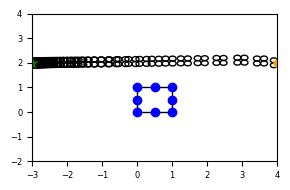

In [7]:
fig, ax = plt.subplots(figsize=(3.0, 2.0))
num_of_obstacles = len(obs_info) #For later use when more obstacles are involved
for i in range(0,num_of_obstacles):
# define the bottom left and top right points of the square
    top_right = obs_info[i][0]
    bottom_left = obs_info[i][1]
    # calculate the width and height of the square
    width = top_right[0] - bottom_left[0]
    height = top_right[1] - bottom_left[1]

    # create a figure and set the axes limits
    
    ax.set_xlim(-3, 4)
    ax.set_ylim(-2, 4)


    # create a square using the width and height and add it to the plot
    square = plt.Rectangle(bottom_left, width, height, fill=False)
    ax.add_patch(square)

first_obstacle_info = obs_info[0]

# Extract the top right and bottom left coordinates
top_right = first_obstacle_info[0]
bottom_left = first_obstacle_info[1]

# Calculate the top left and bottom right coordinates
top_left = np.array([bottom_left[0], top_right[1]])
bottom_right = np.array([top_right[0], bottom_left[1]])

point_1 = (top_right + top_left) / 2
point_2 = (top_left + bottom_left) / 2
point_3 = (bottom_left + bottom_right) / 2
point_4 = (bottom_right + top_right) / 2


# Construct the list of vertices
x_noise = [top_right, top_left, bottom_left, bottom_right, point_1, point_2, point_3, point_4]
for i, point in enumerate(x_noise):
    plt.scatter(point[0], point[1], color="b")
    
# Display the legend to show the labels
#plt.legend()


circle = plt.Circle((x_current[0] - quad_rad, x_current[1] + quad_rad), radius=quad_rad, fill=False)
circle1 = plt.Circle((x_current[0] + quad_rad, x_current[1] + quad_rad), radius=quad_rad, fill=False)
circle2 = plt.Circle((x_current[0] - quad_rad, x_current[1] - quad_rad), radius=quad_rad, fill=False)
circle3 = plt.Circle((x_current[0] + quad_rad, x_current[1] - quad_rad), radius=quad_rad, fill=False)
plt.gca().add_patch(circle)
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)

x_current_list = []
for i in range(60):
    goal = np.array([-3.0, 2.0])
    #goal = np.array([-2.0, -1.0])
    R1.set_goal(goal)
    x_current_list.append(x_current)
    a=R1.generate_control(x_current,quad_rad,x_noise,obs_info)
    h = a[2]
    x_current = h
    #x_current_list.append(x_current)
  
    #ax.scatter(x_current[0], x_current[1], c='r', marker='.')
    circle = plt.Circle((x_current[0] - quad_rad, x_current[1] + quad_rad), radius=quad_rad, fill=False)
    circle1 = plt.Circle((x_current[0] + quad_rad, x_current[1] + quad_rad), radius=quad_rad, fill=False)
    circle2 = plt.Circle((x_current[0] - quad_rad, x_current[1] - quad_rad), radius=quad_rad, fill=False)
    circle3 = plt.Circle((x_current[0] + quad_rad, x_current[1] - quad_rad), radius=quad_rad, fill=False)
    plt.gca().add_patch(circle)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)
ax.scatter(goal[0], goal[1], marker='*', s=50, color='green', label='goal')
ax.scatter(x_current0[0], x_current0[1], marker='.', s=100, color='orange', label='starting point')
ax.tick_params(axis='both', which='major', labelsize=6)
# add legend and display the plot
#ax.legend(loc='upper left', fontsize='x-small')

#ax.set_xlim([-5, 5])
#ax.set_ylim([-5, 5])
#plt.xlabel(r'$x_1$')
#plt.ylabel(r'$x_2$')
plt.tight_layout()
#filename = 'CBF-QP-DISCRETIZATION-RESIZED_3.0.png'  # or any other filename and format you prefer
#plt.savefig(filename, format='png', dpi=300)
plt.show()



In [8]:
x_current_list

[array([4., 2.]),
 array([3.51857143, 2.07285714]),
 array([2.96018723, 2.10538889]),
 array([2.36416851, 2.09485   ]),
 array([1.82775166, 2.085365  ]),
 array([1.34497649, 2.0768285 ]),
 array([0.91047884, 2.06914565]),
 array([0.51943096, 2.06223109]),
 array([0.16748786, 2.05600798]),
 array([-0.14926092,  2.05040718]),
 array([-0.43433483,  2.04536646]),
 array([-0.69090135,  2.04082982]),
 array([-0.92181121,  2.03674683]),
 array([-1.12963009,  2.03307215]),
 array([-1.31666708,  2.02976494]),
 array([-1.48500037,  2.02678844]),
 array([-1.63650034,  2.0241096 ]),
 array([-1.7728503 ,  2.02169864]),
 array([-1.89556527,  2.01952877]),
 array([-2.00600875,  2.0175759 ]),
 array([-2.10540787,  2.01581831]),
 array([-2.19486708,  2.01423648]),
 array([-2.27538038,  2.01281283]),
 array([-2.34784234,  2.01153155]),
 array([-2.4130581 ,  2.01037839]),
 array([-2.47175229,  2.00934055]),
 array([-2.52457706,  2.0084065 ]),
 array([-2.57211936,  2.00756585]),
 array([-2.61490742,  2.00

In [9]:
x_s_list = R1.x_s

In [10]:
x_s_list

[array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([0.91047884, 1.        ]),
 array([0.51943096, 1.        ]),
 array([0.16748786, 1.        ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.])

In [11]:
sigma = 0.35
A = 0.5
J_bar = []
parabolic_3 = []
sqrt_a_sigma = math.sqrt(A/sigma)
for u in range(1, len(x_current_list) + 1):
    x_noise_element = x_s_list[u-1]
    x_current_3 = x_current_list[u-1]
    if np.linalg.norm(x_noise_element - x_current_3) <= sqrt_a_sigma:
        gaus3 = A - (sigma * (np.linalg.norm(x_noise_element - x_current_3)**2))
    else:
        gaus3 = 0

    parabolic_3.append(gaus3)

    if len(parabolic_3) == 1:
        J_x_tb = 0
    elif len(parabolic_3) > 1:
        J_x_of_t3 = J_x_t_func(parabolic_3)
        J_x_tb = J_x_of_t3 *0.1

    J_bar.append(J_x_tb)

In [12]:
J_bar

[0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0015750318064873918,
 0.005517790458056443,
 0.009460897609944455,
 0.01211991742996233,
 0.013743687858620929,
 0.012971958278852303,
 0.009328078226909278,
 0.005596846936145566,
 0.00335810816168734,
 0.002014864897012404,
 0.001208918938207442,
 0.0007253513629244653,
 0.00043521081775467913,
 0.0002611264906528075,
 0.0001566758943916845,
 9.400553663501069e-05,
 5.640332198100641e-05,
 3.3841993188603846e-05,
 2.0305195913162303e-05,
 1.2183117547897382e-05,
 7.30987052873843e-06,
 4.385922317243057e-06,
 2.6315533903458347e-06,
 1.5789320342075004e-06,
 9.473592205245005e-07,
 5.684155323147001e-07,
 3.4104931938882006e-07,
 2.0462959163329207e-07,
 1.2277775497997522e-07,
 7.366665298798513e-08,
 4.419999179279108e-08,
 2.6519995075674645e-08,
 1.5911997045404787e-08,
 9.54719822724287e-09,
 5.728318936345724e-09,
 3.4369913618074335e-09,
 2.0621948170844603e-09,
 1.237316890250676e-09,
 7.423901341504055e-10,
 4.4543408049024333e-10,
 2.672604482

In [33]:
x_bar_noise = []
for a in range (len(x_current_list)):
    point_on_the_line = dist_grad_closest(obs_info[0], x_current_list[a])[2]
    x_bar_noise.append(point_on_the_line)

In [34]:
len(x_s_list)

251

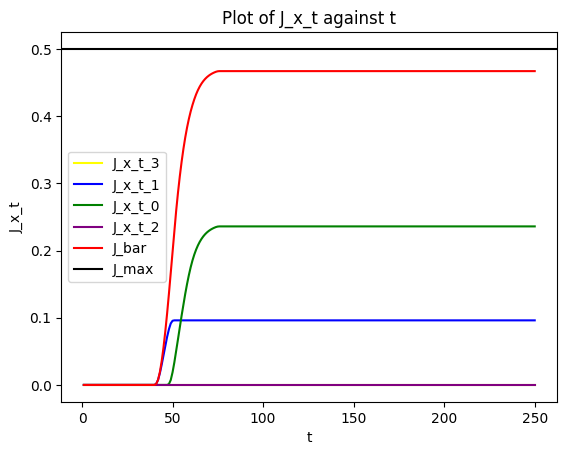

In [35]:
sigma = 1.0
A = 0.5
J_x_t_1 = []
J_x_t_2 = []
J_x_t_4 = []
J_x_t_5 = []
J_bar = []
x_0_noise = obs_info[0][1]
x_1_noise = obs_info[0][0]
x_2_noise = np.array([x_0_noise[0], x_1_noise[1]])
x_3_noise = np.array([x_1_noise[0], x_0_noise[1]])

parabolic_1 = []
parabolic_2 = []
parabolic_3 = []
parabolic_4 = []
parabolic_5 = []
sqrt_a_sigma = math.sqrt(A/sigma)
for t in range(1, len(x_current_list) + 1):
    x_current = x_current_list[t-1]
    if np.linalg.norm(x_0_noise - x_current) <= sqrt_a_sigma:
        gaus = A - (sigma * (np.linalg.norm(x_0_noise - x_current)**2))
    else:
        gaus = 0
    parabolic_1.append(gaus)
    
    if len(parabolic_1) == 1:
        J_x_t = 0
    elif len(parabolic_1) > 1:
        J_x_of_t = J_x_t_func(parabolic_1)
        J_x_t = J_x_of_t * 0.1
        
    J_x_t_1.append(J_x_t)
    
for s in range(1, len(x_current_list) + 1):
    x_current_2 = x_current_list[s-1]
    if np.linalg.norm(x_1_noise - x_current_2) <= sqrt_a_sigma:
        gaus2 = A - (sigma * (np.linalg.norm(x_1_noise - x_current_2)**2))
    else:
        gaus2 = 0
    
    #gaus2 = A * np.exp(-np.linalg.norm(x_noise - x_current_2)**2 / (2*sigma**2))
    parabolic_2.append(gaus2)
    
    if len(parabolic_2) == 1:
        J_x_ta = 0
    elif len(parabolic_2) > 1:
        J_x_of_t2 = J_x_t_func(parabolic_2)
        J_x_ta = J_x_of_t2 *0.1
        
    J_x_t_2.append(J_x_ta)
    
    
for v in range(1, len(x_current_list) + 1):
    x_current_4 = x_current_list[v-1]
    if np.linalg.norm(x_2_noise - x_current_4) <= sqrt_a_sigma:
        gaus4 = A - (sigma * (np.linalg.norm(x_2_noise - x_current_4)**2))
    else:
        gaus4 = 0
    
    #gaus2 = A * np.exp(-np.linalg.norm(x_noise - x_current_2)**2 / (2*sigma**2))
    parabolic_4.append(gaus4)
    
    if len(parabolic_4) == 1:
        J_x_ta = 0
    elif len(parabolic_4) > 1:
        J_x_of_t4 = J_x_t_func(parabolic_4)
        J_x_ta = J_x_of_t4 *0.1
        
    J_x_t_4.append(J_x_ta)

for y in range(1, len(x_current_list) + 1):
    x_current_5 = x_current_list[y-1]
    if np.linalg.norm(x_3_noise - x_current_5) <= sqrt_a_sigma:
        gaus5 = A - (sigma * (np.linalg.norm(x_3_noise - x_current_5)**2))
    else:
        gaus5 = 0
    
    #gaus2 = A * np.exp(-np.linalg.norm(x_noise - x_current_2)**2 / (2*sigma**2))
    parabolic_5.append(gaus5)
    
    if len(parabolic_5) == 1:
        J_x_ta = 0
    elif len(parabolic_5) > 1:
        J_x_of_t5 = J_x_t_func(parabolic_5)
        J_x_ta = J_x_of_t5 *0.1
        
    J_x_t_5.append(J_x_ta)

for u in range(1, len(x_current_list) + 1):
    x_noise_element = x_s_list[u-1]
    x_current_3 = x_current_list[u-1]
    if np.linalg.norm(x_noise_element - x_current_3) <= sqrt_a_sigma:
        gaus3 = A - (sigma * (np.linalg.norm(x_noise_element - x_current_3)**2))
    else:
        gaus3 = 0

    parabolic_3.append(gaus3)

    if len(parabolic_3) == 1:
        J_x_tb = 0
    elif len(parabolic_3) > 1:
        J_x_of_t3 = J_x_t_func(parabolic_3)
        J_x_tb = J_x_of_t3 *0.1

    J_bar.append(J_x_tb)


plt.plot(list(range(1, len(x_current_list) + 1)), J_x_t_1, label='J_x_t_3', color='yellow')
plt.plot(list(range(1, len(x_current_list) + 1)), J_x_t_2, label='J_x_t_1', color='blue')
plt.plot(list(range(1, len(x_current_list) + 1)), J_x_t_4, label='J_x_t_0', color='green')
plt.plot(list(range(1, len(x_current_list) + 1)), J_x_t_5, label='J_x_t_2', color='purple')
plt.plot(list(range(1, len(x_current_list) + 1)), J_bar, label='J_bar', color='red')
plt.axhline(y=0.50, color='black', linestyle='-', label="J_max")
plt.xlabel('t')
plt.ylabel('J_x_t')
plt.title('Plot of J_x_t against t')

# Display the legend
plt.legend()

# Show the plot
plt.show()

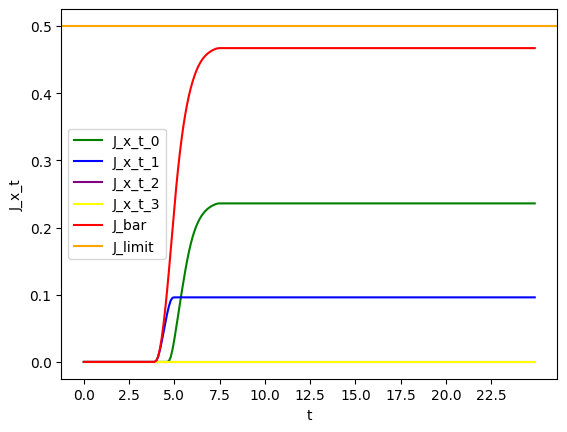

In [36]:
x_ticks = np.arange(0, len(x_current_list)) * 0.1
x_labels = [str(round(i, 1)) for i in x_ticks]

plt.plot(x_ticks, J_x_t_4, label='J_x_t_0', color='green')
plt.plot(x_ticks, J_x_t_2, label='J_x_t_1', color='blue')
plt.plot(x_ticks, J_x_t_5, label='J_x_t_2', color='purple')
plt.plot(x_ticks, J_x_t_1, label='J_x_t_3', color='yellow')
plt.plot(x_ticks, J_bar, label='J_bar', color='red')
plt.axhline(y=0.50, color='orange', linestyle='-', label="J_limit")

plt.xlabel('t')
plt.ylabel('J_x_t')
#plt.title('Plot of J_x_t against t')

# Set the x_ticks and x_labels
plt.xticks(x_ticks[::int(len(x_current_list) * 0.1)], x_labels[::int(len(x_current_list) * 0.1)])  # Adjust the ticks to be visible and not too crowded

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [28]:
x_0_noise = obs_info[0][1]
x_1_noise = obs_info[0][0]
x_2_noise = np.array([x_0_noise[0], x_1_noise[1]])
x_3_noise = np.array([x_1_noise[0], x_0_noise[1]])
x_3_noise

array([1., 0.])

In [29]:
J_bar_dot = parabolic_3

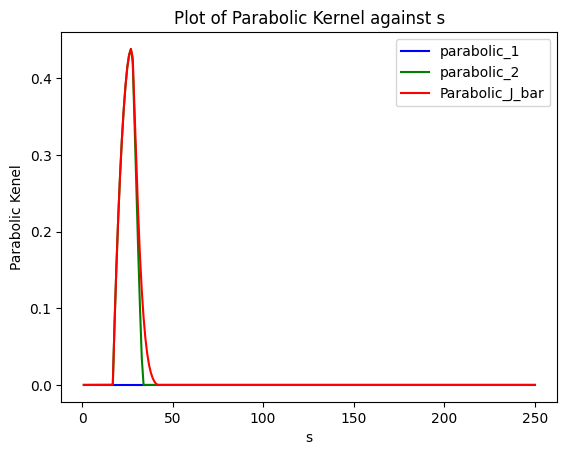

In [30]:
plt.plot(list(range(1, len(parabolic_1) + 1)), parabolic_1, label='parabolic_1', color='blue')
plt.plot(list(range(1, len(parabolic_2) + 1)), parabolic_2, label='parabolic_2', color='green')
plt.plot(list(range(1, len(parabolic_3) + 1)), parabolic_3, label='Parabolic_J_bar', color='red')
plt.xlabel('s')
plt.ylabel('Parabolic Kenel')
plt.title('Plot of Parabolic Kernel against s')

# Display the legend
plt.legend()


In [31]:
maximum = max(parabolic_3)
maximum

0.43804069939604423

In [13]:
index = parabolic_3.index(maximum)
index

53

In [14]:
s_ = index/len(parabolic_3)
s_

0.212

In [15]:
x_s = dist_grad_closest(obs_info[0], x_current_list[index])[2]
x_s

array([0.0160343, 1.       ])

In [16]:
q_t = x_current_list[index]
q_t

array([0.0160343 , 1.20146986])

In [17]:
x_0 = obs_info[0][1]
x_1 = obs_info[0][0]


In [18]:
s_star = np.dot((q_t -x_0), (x_1 - x_0)) / (np.linalg.norm(x_1 -x_0))**2
s_star
if s_star < 0:
    x_star = x_0
elif s_star > 1:
    x_star = x_1
else:
    x_star = (1-s_star)*x_0 + s_star*x_1
    
print (x_star)

[0.0160343 1.       ]


In [19]:
J_bar_dot_x_star = []
for s in range(1, len(x_current_list) + 1):
    x_current_2 = x_current_list[s-1]
    if np.linalg.norm(x_star - x_current_2) <= sqrt_a_sigma:
        para1 = A - (sigma * (np.linalg.norm(x_star - x_current_2)**2))
    else:
        para1 = 0
    
    #gaus2 = A * np.exp(-np.linalg.norm(x_noise - x_current_2)**2 / (2*sigma**2))
    J_bar_dot_x_star.append(para1)

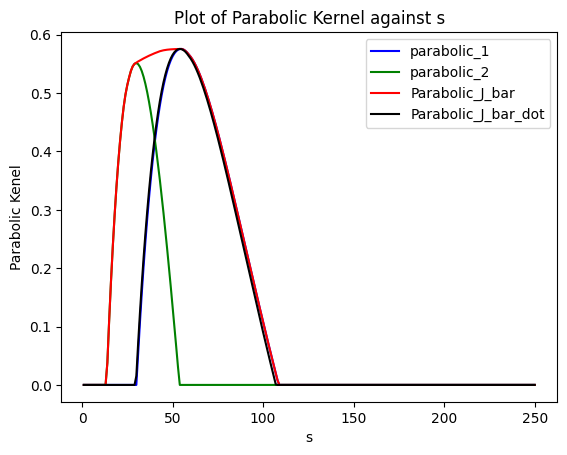

In [20]:
plt.plot(list(range(1, len(parabolic_1) + 1)), parabolic_1, label='parabolic_1', color='blue')
plt.plot(list(range(1, len(parabolic_2) + 1)), parabolic_2, label='parabolic_2', color='green')
plt.plot(list(range(1, len(parabolic_3) + 1)), parabolic_3, label='Parabolic_J_bar', color='red')
plt.plot(list(range(1, len(J_bar_dot_x_star) + 1)), J_bar_dot_x_star, label='Parabolic_J_bar_dot', color='black')
plt.xlabel('s')
plt.ylabel('Parabolic Kenel')
plt.title('Plot of Parabolic Kernel against s')

# Display the legend
plt.legend()

In [21]:
s = (x_s[0] - x_0[0]) / (x_1[0] - x_0[0])
s

0.016034295652206376

In [22]:
x_current_list[249]

array([-1.47109357,  1.00421929])